In [1]:
import torch.jit
import time
from argparse import ArgumentParser
import numpy as np
import torch

import dlrm.scripts.utils as utils
from dlrm.data.data_loader import get_data_loaders
from dlrm.data.utils import get_categorical_feature_sizes, prefetcher
from dlrm.model.single import Dlrm
from dlrm.utils.checkpointing.serial import SerialCheckpointWriter, make_serial_checkpoint_writer, \
    make_serial_checkpoint_loader

Using the Volta-optimized dot interaction kernels


In [2]:
!cat /data/dlrm/binary_dataset/model_size.json

{
    "_c2": 138493,
    "_c3": 26744
}

In [3]:
import pandas as pd

users_mapping = pd.read_parquet('/data/dlrm/spark/output/models/2.parquet',engine='pyarrow')

In [4]:
users_mapping.shape

(138493, 3)

In [5]:
users_mapping

,data,id,model_count
0,14332,130905,641
1,79216,130906,641
2,112063,130907,641
3,130100,130908,641
4,29772,130909,641
5,23637,130910,641
6,126529,130911,641
7,63008,130912,641
8,6780,130913,641
9,136719,130914,641


In [6]:
(905-20)*138493 

122566305

In [7]:
5050*26744 

135057200

In [9]:
items_mapping = pd.read_parquet('/data/dlrm/spark/output/models/3.parquet',engine='pyarrow')

In [10]:
items_mapping.sort_values(by='model_count',  ascending=False)

,data,id,model_count
26735,296,1,73508
26736,356,2,72111
26737,318,3,70577
26738,593,4,69924
26739,480,5,66538
26740,110,6,61959
26741,260,7,61789
26742,589,8,60295
26743,527,9,59151
18192,457,10,58794


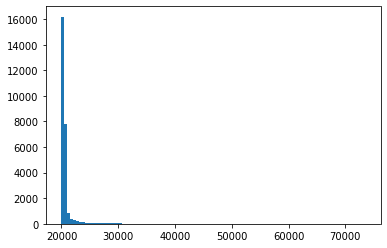

In [11]:
import matplotlib.pyplot as plt
plt.hist(items_mapping['model_count'],100);

In [12]:
np.max(items_mapping['id'])

26744

In [13]:
np.sum(items_mapping['model_count'])

556298482

In [14]:
np.sum(users_mapping['model_count'])

556298482

In [15]:
class flag(object):
    def __init__(self):
        
        # Model configuration
        self.embedding_type = "joint" # The type of the embedding operation to use")
        self.embedding_dim = 64 # "Dimensionality of embedding space for categorical features")
        self.top_mlp_sizes = [64, 1] # "Linear layer sizes for the top MLP")
        self.bottom_mlp_sizes = [128, 64] #Linear layer sizes for the bottom MLP")

        self.interaction_op ="cuda_dot" #"Type of interaction operation to perform.")

        self.dataset = "/data/dlrm/binary_dataset/"
        self.dataset_type = "split" #The type of the dataset to use')

        self.base_device = "cuda" #"Device to run the majority of the model operations")
        self.amp = False #If True the script will use Automatic Mixed Precision")
        self.optimized_mlp = True #Use an optimized implementation of MLP from apex")
        self.max_table_size = None #Maximum number of rows per embedding table, by default equal to the number of unique values for each categorical variable")
        self.num_numerical_features = 1
        self.hash_indices = False

In [16]:
FLAGS = flag()

print("Creating model")

model_config = {
    'top_mlp_sizes': FLAGS.top_mlp_sizes,
    'bottom_mlp_sizes': FLAGS.bottom_mlp_sizes,
    'embedding_type': FLAGS.embedding_type,
    'embedding_dim': FLAGS.embedding_dim,
    'interaction_op': FLAGS.interaction_op,
    'categorical_feature_sizes': get_categorical_feature_sizes(FLAGS),
    'num_numerical_features': FLAGS.num_numerical_features,
    'hash_indices': FLAGS.hash_indices,
    'use_cpp_mlp': FLAGS.optimized_mlp,
    'fp16': FLAGS.amp,
    'base_device': FLAGS.base_device,
}

model = Dlrm.from_dict(model_config)
print(model)

Creating model
feature sizes:  [138494, 26745]
Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 138494 165239]
      (embedding): Embedding(165239, 64, sparse=True)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [1, 128, 64], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [68, 64], Bias=1, activation=1)
    )
    (out): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [17]:
checkpoint_loader = make_serial_checkpoint_loader(
            embedding_indices=range(len(get_categorical_feature_sizes(FLAGS))),
            device="cpu"
        )
checkpoint_loader.load_checkpoint(model, "/workspace/dlrm_vinhn/notebooks/movie_lens_model-smallnet")
model.eval()
model.to(FLAGS.base_device)

feature sizes:  [138494, 26745]


RuntimeError: Error(s) in loading state_dict for Linear:
	size mismatch for weight: copying a param with shape torch.Size([1, 256]) from checkpoint, the shape in current model is torch.Size([1, 64]).

In [ ]:
model.bottom_model.embeddings.embedding.weight.shape

In [18]:
embedding = model.bottom_model.embeddings.embedding.weight.detach().cpu().numpy()

In [ ]:
item_embedding = embedding[138494:]
item_embedding.shape

In [ ]:
plt.hist(np.linalg.norm(item_embedding, axis=1),100);

In [ ]:
from scipy.spatial.distance import cdist
def find_similar_movies(nn_movie_id, item_embedding, k=10, metric='cosine'):
    sim = -cdist(item_embedding, item_embedding[nn_movie_id].reshape(1, -1), metric=metric)
    #sim = np.matmul(item_embedding, item_embedding[nn_movie_id].transpose())
    return sim.squeeze().argsort()[-k:][::-1]

In [ ]:
nn_to_movies = {}
movies_to_nn = {}
for _, row in items_mapping.iterrows():
    movies_to_nn[int(row['data'])] = int(row['id'])
    nn_to_movies[int(row['id'])] = int(row['data'])


In [ ]:
import pandas as pd
movies = pd.read_csv("/mnt/dldata/vinhn/DeepLearningExamples/PyTorch/Recommendation/NCF/data/ml-20m/movies.csv", index_col="movieId")

movie_ID = 1196 
print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

print("Similar movies: ")
similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

for i in similar_movies:
    if i==0:
        continue
    print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])

In [ ]:
for movie_ID in range(1000):
    try:
        print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

        print("Similar movies: ")
        similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

        for i in similar_movies:
            if i==0:
                continue
            print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])
        print('===============\n')
    except Exception as e:
        print(e)
        pass